In [1]:
import lbforaging
from games.foraging import Foraging 
import numpy as np
import time
from agents.random_agent import RandomAgent
from agents.independent_q_learning import IQL

In [2]:
game = Foraging(config= "Foraging-5x5-2p-4f-v3")

c:\Users\kidni\Desktop\sistemas-multiagente\.venv\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
game.reset()

#print game information
rewards = game.rewards
observations = game.observations
terminations = game.terminations
truncations = game.truncations
infos = game.infos
print("Game Information:")
print("Rewards: ", rewards)
print("Observations: ", observations)
print("Terminations: ", terminations)

print("Truncations: ", truncations)
print("Infos: ", infos)

Game Information:
Rewards:  {'agent_0': None, 'agent_1': None}
Observations:  {'agent_0': None, 'agent_1': None}
Terminations:  {'agent_0': False, 'agent_1': False}
Truncations:  {'agent_0': False, 'agent_1': False}
Infos:  {'agent_0': {}, 'agent_1': {}}


In [4]:

def change_epsilon(iteration, min_epsilon=0.03, max_epsilon=0.9):
    epsilon = max(min_epsilon, min(max_epsilon, 3 - np.log10((iteration + 1))))
    return epsilon

def change_alpha(iteration, min_alpha=0.01, max_alpha=1.0):
    alpha = max(min_alpha, min(max_alpha, 3 - np.log10((iteration + 1))))
    return alpha


In [5]:
def train(game, agents, n_episodes=1000, verbose=False, render=False):
    rewards_per_episode = []

    for episode in range(n_episodes):
        # Reinicia el entorno
        game.reset()

        cum_rewards = dict(map(lambda agent: (agent, 0), game.agents))

        if render:
            game.render()
            time.sleep(0.5)

        while not game.done():
            actions = dict(map(lambda agent: (agent, agents[agent].action()), game.agents))
            game.step(actions)

            for agent in game.agents:
                reward = game.reward(agent)
                next_obs = game.observe(agent)
                cum_rewards[agent] += reward

            if render:
                game.render()
                time.sleep(0.5)

        # Guarda la recompensa total del episodio
        total_reward = sum(cum_rewards.values())
        rewards_per_episode.append(total_reward)

        # --- NUEVO: actualizar epsilon y alpha dinámicamente ---
        for agent in agents.values():
            if hasattr(agent, 'epsilon'):
                agent.epsilon = change_epsilon(episode)
            if hasattr(agent, 'alpha'):
                agent.alpha = change_alpha(episode)

        if verbose:
            print(f"Episode {episode + 1}/{n_episodes} - Total Reward: {total_reward}")
            print(f"Epsilon: {agents[game.agents[0]].epsilon:.4f}, Alpha: {agents[game.agents[0]].alpha:.4f}")

    return rewards_per_episode


c:\Users\kidni\Desktop\sistemas-multiagente\.venv\lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


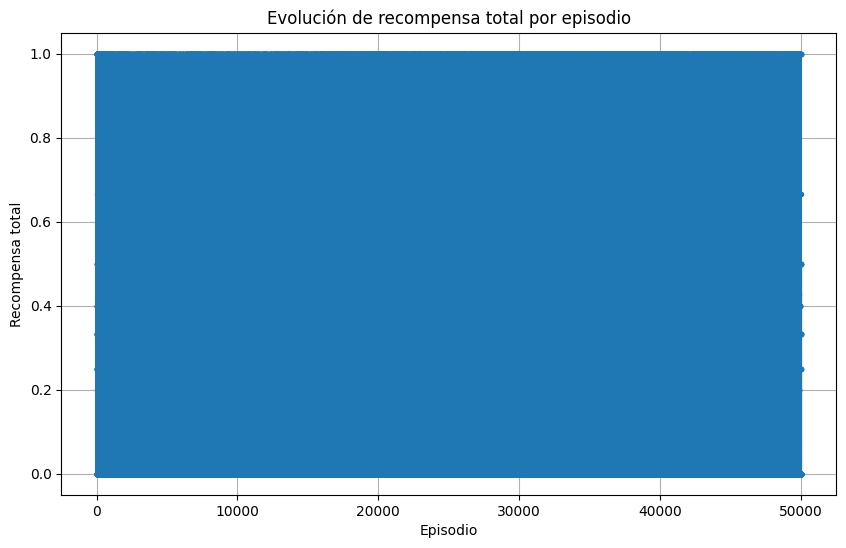

In [6]:
# Crear los agentes
agents = {agent: IQL(game, agent) for agent in game.agents}

shared_agent = IQL(game, "agent_0")
#agents = {agent: shared_agent for agent in game.agents}


# Entrenar los agentes
rewards = train(game, agents, n_episodes=50000, verbose=False, render=False)

# Graficar las recompensas
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rewards, marker='o', markersize=3, linestyle='-')
plt.title("Evolución de recompensa total por episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid()
plt.show()

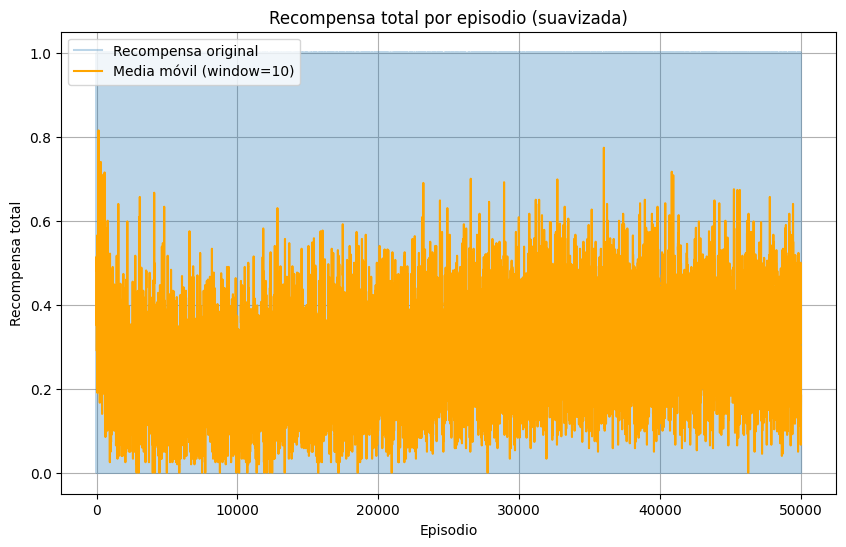

In [7]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Crear la curva suavizada
window = 10
smoothed = moving_average(rewards, window)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(rewards, alpha=0.3, label='Recompensa original')
plt.plot(range(window-1, len(rewards)), smoothed, color='orange', label=f'Media móvil (window={window})')
plt.title("Recompensa total por episodio (suavizada)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.legend()
plt.grid()
plt.show()


In [8]:
def evaluate_policy(game, agents, n_episodes=1000, block_size=100, render=False):
    # Fijar epsilon en 0 para política greedy (sin exploración)
    for agent in agents.values():
        agent.epsilon = 0.0

    success_per_episode = []

    for episode in range(n_episodes):
        game.reset()
        total_reward = 0

        if render:
            game.render()

        while not game.done():
            actions = {agent_id: agents[agent_id].action() for agent_id in game.agents}
            game.step(actions)
            total_reward += sum(r if r is not None else 0 for r in game.rewards.values())

            if render:
                game.render()

        # Éxito si al menos una recolección ocurrió (recompensa total positiva)
        success_per_episode.append(1 if total_reward > 0 else 0)

    # Calcular porcentaje de éxito por bloque de 100 episodios
    blocks = len(success_per_episode) // block_size
    success_rate = [
        np.mean(success_per_episode[i*block_size:(i+1)*block_size])
        for i in range(blocks)
    ]

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, blocks+1), success_rate, marker='o', linestyle='-')
    plt.title(f"Porcentaje de éxito cada {block_size} episodios (evaluación sin exploración)")
    plt.xlabel(f"Bloque de {block_size} episodios")
    plt.ylabel("Tasa de éxito")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.show()

    return success_rate


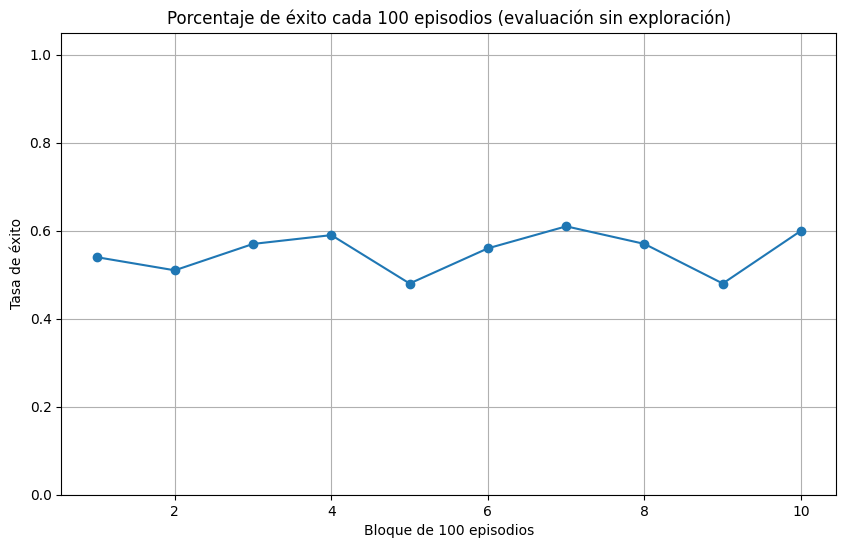

[np.float64(0.54),
 np.float64(0.51),
 np.float64(0.57),
 np.float64(0.59),
 np.float64(0.48),
 np.float64(0.56),
 np.float64(0.61),
 np.float64(0.57),
 np.float64(0.48),
 np.float64(0.6)]

In [9]:
evaluate_policy(game, agents, n_episodes=1000, block_size=100, render=False)


In [10]:
#save the agents
import pickle
with open("agents.pkl", "wb") as f:
    pickle.dump(agents, f)

    